In [1]:
import rasterio as rio
from rasterio.plot import show
import torch
import segmentation_models_pytorch as smp
from Utils import presentation_utils as pu

/home/adsp/miniconda3/envs/newadspenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = smp.Unet(encoder_name="resnet50", encoder_weights=None, in_channels=10)
model.encoder.load_state_dict(torch.load("models/trained_models/ben.pth"), strict=False)

In [3]:
print("Tiling test image...")
pu.tiling(initial_img_path="tmp/test_img.tiff")
print("Making prediction...")
pu.make_predictions(model=model)

Tiling test image...
Loading initial image into memory...


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Test image shape: (13, 1357, 1653)
Computing tiles...
Making prediction...


  0%|          | 0/12 [00:00<?, ?it/s]/home/adsp/miniconda3/envs/newadspenv/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 1357, 1653)


/home/adsp/miniconda3/envs/newadspenv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


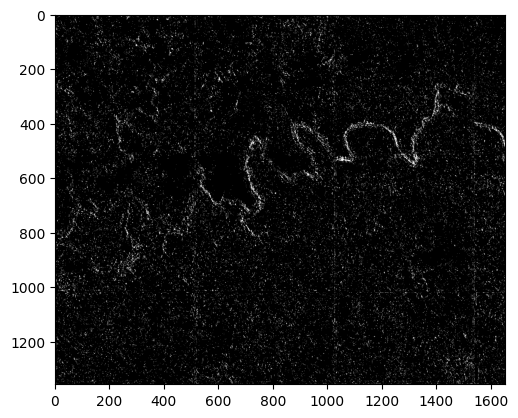

/home/adsp/miniconda3/envs/newadspenv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


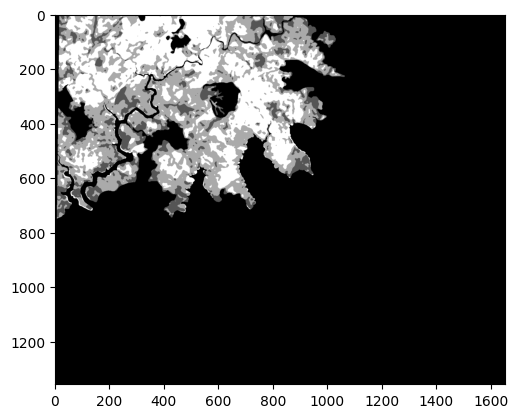

<AxesSubplot: >

In [4]:
print("Assembling final prediction...")
final_prediction, shape_crop = pu.merge_tiles(test_img_path="tmp/test_img.tiff")
show(final_prediction[:, :, 512:shape_crop+512], cmap="gray")
gt_mask = rio.open("tmp/test_mask.tiff", "r").read()
show(gt_mask, cmap="gray")